# Spam detection with Support Vector Machine

E-mail is one of the most secure medium for online communication and transferring data through the web. With its increase in popularity, the number of ill-intentioned/unsolicited emails has also increased rapidly. To filtering data, there are different approaches which automatically classify these messages. The one I picked for this project was a support vector classifier, a method I first experimented within this Bootcamp.
An SVM works well in a binary classification task such as this one. It separates spam from non-spam (aka ham) by drawing a separator known as a hyperplane between the classes.

### Learning goals

- Develop a deep understanding of SVM concepts and implement them
- Practice data exploration and preprocessing
- Feature extraction with PCA/SVD/LDA
- Apply SVM to a non linear problem with a custom non linear kernel.

## Libraries

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Import the dataset

In [2]:
df = pd.read_csv("datasets/emails_raw.csv")

df.describe

# print the number of rows and columns
df.shape

(11120, 2)

## Exploring the Dataset

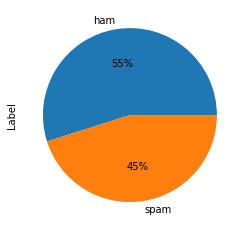

In [3]:
classes = pd.value_counts(df["Label"], sort= True)
classes.plot(kind = 'pie',  autopct='%1.0f%%')
plt.show()

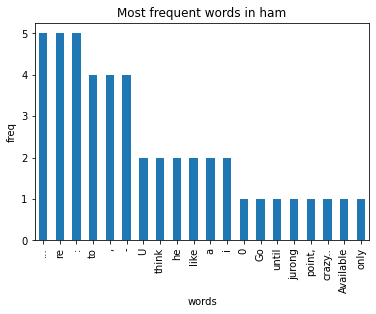

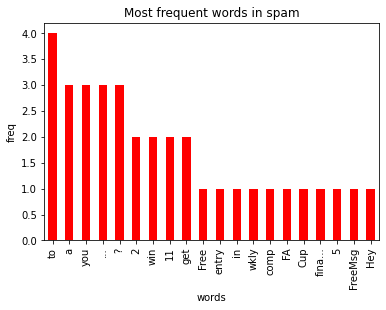

In [4]:
count1 = Counter("".join(str(df[df['Label'] == 'ham']["EmailText"])).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "ham", 1 : "count"})

count2 = Counter("".join(str(df[df['Label'] =='spam']["EmailText"])).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "spam", 1 : "count_"})

df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["ham"]))
plt.xticks(y_pos, df1["ham"])
plt.title('Most frequent words in ham')
plt.xlabel('words')
plt.ylabel('freq')
plt.show()

df2.plot.bar(legend = False, color = 'red')
y_pos = np.arange(len(df2["spam"]))
plt.xticks(y_pos, df2["spam"])
plt.title('Most frequent words in spam')
plt.xlabel('words')
plt.ylabel('freq')
plt.show()

## Data Cleaning

### Data cleaning method
With regexes and nltk I preprocess the data to make it easier to learn for the SVM. In order, I'm: turning all letters to lowercase, encoding URLs, email addresses and 
 numbers, and converting punctuation and newlines to  whitespace. I attempted word stemming with nltk to further increase performance. While scikit learn's feature extraction function does have a "remove stopwords" argument, I removed stopwords in the same place as all the other preprocessing ops, with a regular expression. Regular expressions carry out their function at a low level and are heavily optimised making them likely quicker than any other alternatives out there.

In [5]:
def sanitise(email):
    # convert text to lowercase
    email = email.lower()

    # convert URLs to 'httpaddr'
    email = re.sub(r'(http|https)://[^\s]*', r' httpaddr ', email)

    # convert email addresses to 'emailaddr'
    email = re.sub(r'[^\s]+@[^\s]+[.][^\s]+', r' emailaddr ', email)

    # convert numbers to 'number'
    email = re.sub(r'[0-9]+', r' number ', email)

    # convert $, ! and ? to proper words
    email = re.sub(r'[$]', r' dollar ', email)
    email = re.sub(r'[!]', r' exclammark ', email)
    email = re.sub(r'[?]', r' questmark ', email)

    # convert other punctuation to whitespace
    email = re.sub(r'([^\w\s]+)|([_-]+)', r' ', email)

    # convert newlines and blanklines to special strings and extra whitespace to single
    email = re.sub(r'\n', r' newline ', email)
    email = re.sub(r'\n\n', r' blankline ', email)
    email = re.sub(r'\s+', r' ', email)
    email = email.strip(' ')
    
    # remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(nltk.corpus.stopwords.words('english')) + r')\b\s*')
    email = pattern.sub('', email)

    # perform word stemming
    emailWords = email.split(' ')
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    stemWords = [stemmer.stem(word) for word in emailWords]
    email = ' '.join(stemWords)
    
    return email

In [6]:
# Apply sanitise data
df["EmailText"] = df["EmailText"].apply(sanitise)

# Drop all rows with missing data
df.dropna(axis=0, how='any')

# Remove duplicates
df.drop_duplicates(inplace=True)

df.describe

<bound method NDFrame.describe of       Label                                          EmailText
0       ham  go jurong point crazi avail bugi n great world...
1       ham                              ok lar joke wif u oni
2      spam  free entri number wkli comp win fa cup final t...
3       ham                u dun say earli hor u c alreadi say
4       ham               nah think goe usf live around though
...     ...                                                ...
11115   ham  p spread option jeff short follow p option att...
11116   ham  resum molli would like invit student interview...
11117   ham  confidenti sophi think fair deal vinc sophi ki...
11118   ham  chang video teleconfer enron christi meet numb...
11119   ham  evalu enron remind pleas pass along other may ...

[10537 rows x 2 columns]>

## Split the dataset 75-25

In [7]:
x = df["EmailText"]
y = df["Label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

## Feature Extraction

Term frequency-inverse document frequency is proven to improve text classification ([see Jing et al](https://ieeexplore.ieee.org/abstract/document/1174522) and [Guo et al](https://www.sciencedirect.com/science/article/abs/pii/S0925231219310276)). Tf-idf vectoriser transforms each email into a sparse matrix of numerical representations of weight of words. This conversion makes it easier for a learning model to pick up on the information an email holds, as it deals with overall document weightage of a word. Its alternative, `CountVectorizer` only counts the number of times a word appears in the document which results in bias in favour of most frequent words. This way, it ends up ignoring rare words which could have helped in processing our data more efficiently. 

In [8]:
cv = TfidfVectorizer()
features = cv.fit_transform(x_train)

# No of rows and the length of all tfidf vectors 
features.shape
# features[0] returns <1x39653 sparse matrix of type '<class 'numpy.float64'>' 	with 9 stored elements in Compressed Sparse Row format>

(7902, 38867)

## Build and train the model

In [9]:
tuned_parameters1 = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],'C': [1, 100, 1000]}
model = GridSearchCV(svm.SVC(), tuned_parameters)
model.fit(features, y_train)

# Training accuracy 
model.score(cv.transform(x_train), y_train)

0.9731713490255631

In [10]:
# Best hyperparameters
model.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

## Prediction and evaluation

<AxesSubplot:>

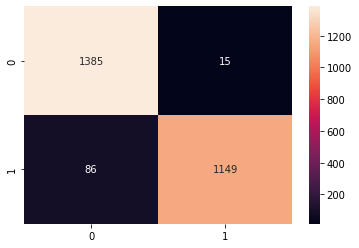

In [11]:
y_pred = model.predict(cv.transform(x_test))

# Show confusion matrix, i.e. all TN TP FN FP
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [12]:
# Classification report includes recall, precision, F1 score
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n         ham       0.94      0.99      0.96      1400\n        spam       0.99      0.93      0.96      1235\n\n    accuracy                           0.96      2635\n   macro avg       0.96      0.96      0.96      2635\nweighted avg       0.96      0.96      0.96      2635\n'

In [13]:
# Test accuracy
model.score(cv.transform(x_test), y_test)

0.9616698292220114